In [60]:
import pandas as pd
import numpy as np
import missingno as mo

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn import tree # For plotting the decision tree rule
from sklearn.linear_model import LogisticRegression as Logit

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

#plotting
from plotnine import *
import matplotlib.pyplot as plt

# permutation
from sklearn.inspection import permutation_importance

In [61]:
jordan = pd.read_csv("arabbaro/arabbaro_jo_labeled_reduced.csv")

In [62]:
jordan.drop(columns = ["y_dem_top_issue", "y_dem_pref", "y_trust_army", "y_trust_pres_prime", "y_trust_ikhwan", "Unnamed: 0"],inplace = True)

In [63]:
kuwait = pd.read_csv("arabbaro/arabbaro_kuw_labeled_reduced.csv")

In [64]:
kuwait.drop(columns = ["y_dem_top_issue", "y_dem_pref", "y_trust_army", "y_trust_pres_prime", "y_trust_ikhwan", "Unnamed: 0"], inplace = True)

In [65]:
egypt = pd.read_csv("arabbaro/arabbaro_egy_labeled_reduced.csv")

In [66]:
egypt.drop(columns = ["y_dem_top_issue", "y_dem_pref", "y_trust_army", "y_trust_pres_prime", "y_trust_ikhwan", "Unnamed: 0"], inplace = True)

In [67]:
morocco = pd.read_csv("arabbaro/arabbaro_mor_labeled_reduced.csv")

In [68]:
morocco.drop(columns = ["y_dem_top_issue", "y_dem_pref", "y_trust_army", "y_trust_pres_prime", "y_trust_ikhwan", "Unnamed: 0"], inplace = True)

In [69]:
algeria = pd.read_csv("arabbaro/arabbaro_alg_labeled_reduced.csv")

In [70]:
algeria.drop(columns = ["y_dem_top_issue", "y_dem_pref", "y_trust_army", "y_trust_pres_prime", "y_trust_ikhwan", "Unnamed: 0"],inplace = True)

In [71]:
def dempref(df):
    # set up SKLearn Framework
    y = df.y_2_dem_pref_not_in_dem
    if 'y_1_trust_gov' in df.columns:
        X = df.drop(columns = ["y_2_dem_pref_not_in_dem", "y_1_trust_gov"])
    else:  
        X = df.drop(columns = "y_2_dem_pref_not_in_dem")

    train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1234)

    # Set the folds index to ensure comparable samples
    fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

    # Build the modeling pipeline
    pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])

    search_space = [
    
        # NaiveBayes
        {'model': [NB()]},
    
        # KNN with K tuning param
        {'model' : [KNN()],
        'model__n_neighbors':[5,10,25,50]},
    
        # Decision Tree with the Max Depth Param
        {'model': [DT()],
        'model__max_depth':[2,3,4]},
    
        # Random forest with the N Estimators, max depth, and max features tuning param
        {'model' : [RF()],
        'model__max_depth':[6,7,8],
        'model__n_estimators':[500,1000,1500],
        'model__max_features': [5,10,15]},
        
        # logit model
        {'model': [Logit()],
        'model__class_weight':[None, "balanced"]},
    
    ]

    # Grid Search to find the best parameters. The metric used for evaluation is ROC AUC
    search = GridSearchCV(pipe, search_space, 
                         cv = fold_generator,
                         scoring='roc_auc',
                         n_jobs=4)

    # fit the data with the model
    search.fit(train_X,train_y)
    
    best_mod = search.best_estimator_

    return(search.best_score_, search.best_estimator_, search.predict(test_X), m.plot_confusion_matrix(best_mod, test_X, test_y), train_X, test_X, train_y, test_y)

In [72]:
def trustgov(df):
    # set up SKLearn Framework
    y = df.y_1_trust_gov
    if 'y_2_dem_pref_not_in_dem' in df.columns:
        X = df.drop(columns = ["y_2_dem_pref_not_in_dem", "y_1_trust_gov"])
    else:  
        X = df.drop(columns = "y_1_trust_gov")
    train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1234)

    # Set the folds index to ensure comparable samples
    fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

    # Build the modeling pipeline
    pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])

    search_space = [
    
        # NaiveBayes
        {'model': [NB()]},
    
        # KNN with K tuning param
        {'model' : [KNN()],
        'model__n_neighbors':[5,10,25,50]},
    
        # Decision Tree with the Max Depth Param
        {'model': [DT()],
        'model__max_depth':[2,3,4]},
    
        # Random forest with the N Estimators, max depth, and max features tuning param
        {'model' : [RF()],
        'model__max_depth':[6,7,8],
        'model__n_estimators':[500,1000,1500],
        'model__max_features': [5,10,15]},
        
        # logit model
        {'model': [Logit()],
        'model__class_weight':[None, "balanced"]},
    
    ]

    # Grid Search to find the best parameters. The metric used for evaluation is ROC AUC
    search = GridSearchCV(pipe, search_space, 
                         cv = fold_generator,
                         scoring='roc_auc',
                         n_jobs=4)

    # fit the data with the model
    search.fit(train_X,train_y)
    
    best_mod = search.best_estimator_

    return(search.best_score_, search.best_estimator_, search.predict(test_X), m.plot_confusion_matrix(best_mod, test_X, test_y), train_X, test_X, train_y, test_y)

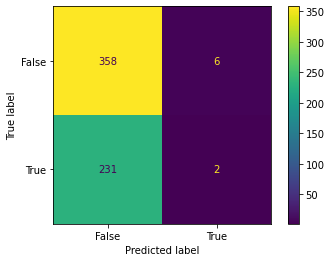

In [73]:
score, best_mod, pred_y, confusion, train_X, test_X, train_y, test_y = dempref(jordan)

In [74]:
score

0.5566872071463816

In [75]:
threshold1 = 0.8

In [76]:
threshold2 = 0.2

In [77]:
# use predict probabilities function
pred_threshold1 = (best_mod.predict_proba(test_X)[:,1] >= threshold1).astype(int)

In [78]:
pred_threshold1

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [79]:
pred_threshold2 = (best_mod.predict_proba(test_X)[:,1] >= threshold2).astype(int)

In [80]:
pred_threshold2

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [81]:
m.confusion_matrix(test_y, classes)

array([[364,   0],
       [233,   0]])

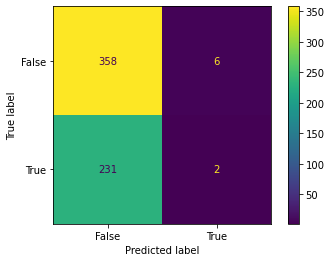

In [82]:
confusion.figure_

In [83]:
best_mod

Pipeline(steps=[('pre_process', MinMaxScaler()),
                ('model',
                 RandomForestClassifier(max_depth=6, max_features=5,
                                        n_estimators=500))])

In [84]:
# permutation
vi = permutation_importance(best_mod,train_X,train_y,n_repeats=5)

In [85]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                        vi = vi['importances_mean'],
                        std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,age,0.017309,0.001934,1.344042e-02,0.021177
1,male,0.010720,0.001430,7.860134e-03,0.013580
2,infs_socmed,0.009157,0.002016,5.124406e-03,0.013189
3,educ,0.008599,0.001150,6.299133e-03,0.010898
4,retired,0.008487,0.000741,7.005416e-03,0.009968
5,neighb_rich,0.008264,0.001192,5.878933e-03,0.010648
6,internet_use_ordinal_4_is_top,0.007259,0.001539,4.180000e-03,0.010337
7,internet_use_bin,0.007147,0.001882,3.383071e-03,0.010911
8,employed_priv_sec,0.006700,0.000353,5.993908e-03,0.007406
9,housewife,0.006030,0.000893,4.243439e-03,0.007817


In [86]:
vi_dat.to_csv("variable importance csv/jordan_y2")

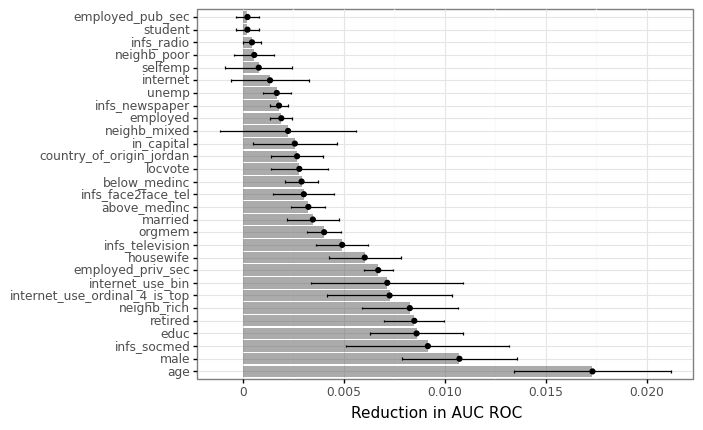

<ggplot: (8784945474431)>

In [87]:
# Plot
(
    ggplot(vi_dat,
        aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

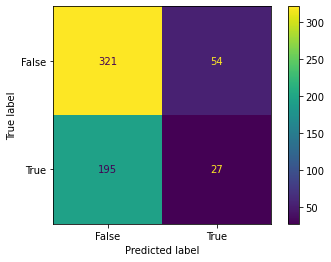

In [88]:
score, best_mod, pred_y, confusion, train_X, test_X, train_y, test_y = trustgov(jordan)

In [89]:
score

0.5860997063624547

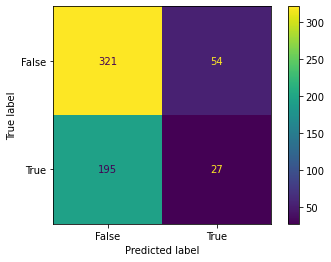

In [90]:
confusion.figure_

In [91]:
pred_threshold1 = (best_mod.predict_proba(test_X)[:,1] >= threshold1).astype(int)

In [92]:
pred_threshold1

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [93]:
pred_threshold2 = (best_mod.predict_proba(test_X)[:,1] >= threshold2).astype(int)

In [94]:
pred_threshold2

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [95]:
best_mod

Pipeline(steps=[('pre_process', MinMaxScaler()),
                ('model', LogisticRegression())])

In [96]:
# permutation
vi = permutation_importance(best_mod,train_X,train_y,n_repeats=5)

In [97]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                        vi = vi['importances_mean'],
                        std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,educ,0.013400,0.002712,0.007975,0.018825
1,above_medinc,0.013400,0.003331,0.006737,0.020063
2,internet,0.007482,0.002860,0.001762,0.013202
3,retired,0.006924,0.005051,-0.003179,0.017026
4,infs_face2face_tel,0.003350,0.004396,-0.005443,0.012143
5,male,0.003015,0.003506,-0.003998,0.010028
6,infs_radio,0.003015,0.002358,-0.001702,0.007732
7,selfemp,0.002792,0.003670,-0.004548,0.010131
8,neighb_rich,0.002457,0.003343,-0.004229,0.009142
9,infs_television,0.002233,0.002976,-0.003718,0.008184


In [98]:
vi_dat.to_csv("variable importance csv/jordan_y1")

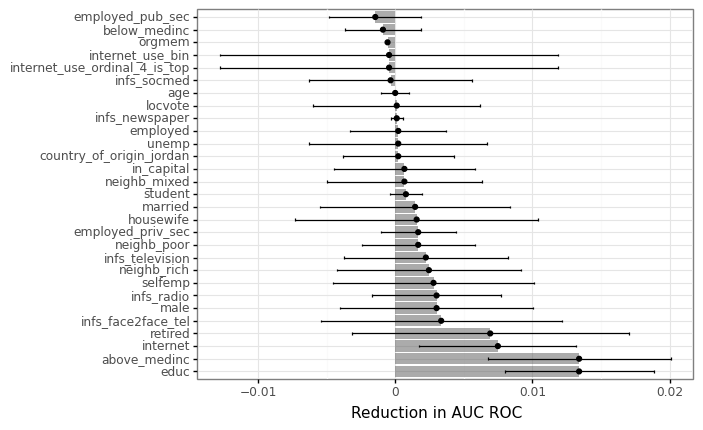

<ggplot: (8784933043857)>

In [99]:
# Plot
(
    ggplot(vi_dat,
        aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

In [100]:
kuwait.isna().sum()

below_medinc             0
above_medinc             0
in_capital               0
married                  0
employed                 0
employed_pub_sec         0
employed_priv_sec        0
selfemp                  0
retired                  0
housewife                0
student                  0
unemp                    0
neighb_rich           1364
neighb_poor           1364
neighb_mixed          1364
educ                     0
male                     0
age                      0
orgmem                   0
locvote                  0
internet                 0
internet_use_bin         0
infs_face2face_tel       0
infs_newspaper           0
infs_radio               0
infs_television          0
infs_socmed              0
y_1_trust_gov            0
dtype: int64

In [101]:
kuwait.drop(columns = ["neighb_rich", "neighb_poor", "neighb_mixed"], inplace = True)

In [102]:
kuwait

,below_medinc,above_medinc,in_capital,married,employed,employed_pub_sec,employed_priv_sec,selfemp,retired,housewife,...,orgmem,locvote,internet,internet_use_bin,infs_face2face_tel,infs_newspaper,infs_radio,infs_television,infs_socmed,y_1_trust_gov
0,False,False,False,True,True,True,False,False,False,False,...,False,False,True,1.0,False,False,False,False,True,False
1,False,True,False,True,True,True,False,False,False,False,...,True,True,True,1.0,False,False,False,False,True,True
2,False,False,False,True,False,False,False,False,True,False,...,False,False,True,0.8,False,False,False,False,True,False
3,True,False,False,True,False,False,False,False,True,False,...,False,True,True,1.0,False,False,False,False,True,False
4,True,False,False,True,True,True,False,False,False,False,...,False,False,True,1.0,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1359,False,True,False,True,False,False,False,False,True,False,...,False,True,True,0.8,False,False,False,False,True,True
1360,False,False,False,False,False,False,False,False,False,False,...,True,False,True,1.0,False,False,False,False,True,True
1361,False,False,False,True,True,True,False,False,False,False,...,False,True,True,1.0,False,False,False,False,True,False
1362,False,False,False,True,True,True,False,False,False,False,...,True,True,True,1.0,False,False,False,False,True,False


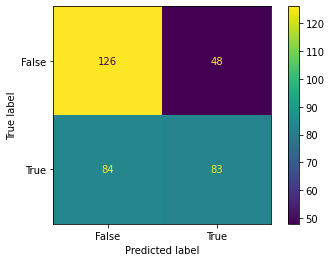

In [103]:
score, best_mod, pred_y, confusion, train_X, test_X, train_y, test_y = trustgov(kuwait)

In [104]:
score

0.6545841643212535

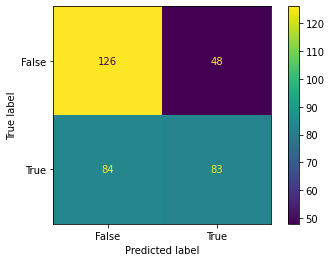

In [105]:
confusion.figure_

In [106]:
best_mod

Pipeline(steps=[('pre_process', MinMaxScaler()),
                ('model',
                 RandomForestClassifier(max_depth=6, max_features=5,
                                        n_estimators=1000))])

In [107]:
pred_threshold1 = (best_mod.predict_proba(test_X)[:,1] >= threshold1).astype(int)

In [108]:
pred_threshold1

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [109]:
pred_threshold2 = (best_mod.predict_proba(test_X)[:,1] >= threshold2).astype(int)

In [110]:
pred_threshold2

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [111]:
# permutation
vi = permutation_importance(best_mod,train_X,train_y,n_repeats=5)

In [112]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                        vi = vi['importances_mean'],
                        std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,infs_socmed,0.088759,0.011322,0.066114,0.111403
1,age,0.048094,0.003881,0.040333,0.055855
2,retired,0.025611,0.001682,0.022247,0.028975
3,above_medinc,0.025024,0.004526,0.015972,0.034077
4,educ,0.017986,0.001813,0.014360,0.021612
5,locvote,0.015836,0.002723,0.010390,0.021282
6,male,0.012708,0.004328,0.004052,0.021363
7,orgmem,0.012708,0.002050,0.008607,0.016809
8,in_capital,0.012317,0.002280,0.007757,0.016877
9,internet_use_bin,0.010753,0.003658,0.003438,0.018068


In [113]:
vi_dat.to_csv("variable importance csv/kuwait_y1")

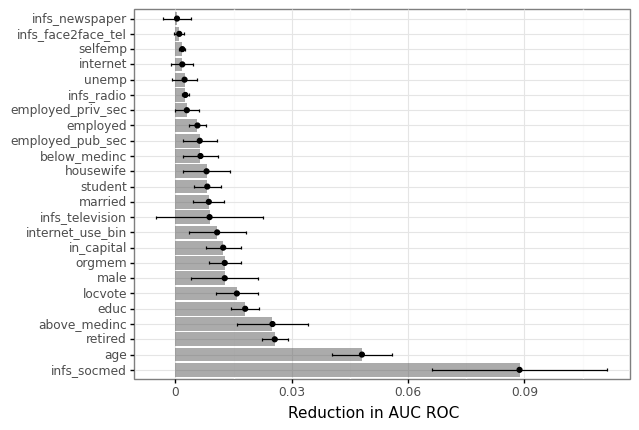

<ggplot: (8784932446389)>

In [114]:
# Plot
(
    ggplot(vi_dat,
        aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

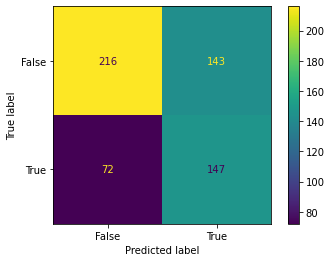

In [115]:
score, best_mod, pred_y, confusion, train_X, test_X, train_y, test_y = dempref(morocco)

In [116]:
score

0.7140173756153516

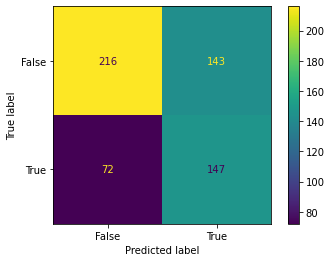

In [117]:
confusion.figure_

In [118]:
best_mod

Pipeline(steps=[('pre_process', MinMaxScaler()),
                ('model', LogisticRegression(class_weight='balanced'))])

In [119]:
pred_threshold1 = (best_mod.predict_proba(test_X)[:,1] >= threshold1).astype(int)

In [120]:
pred_threshold1

array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [121]:
pred_threshold2 = (best_mod.predict_proba(test_X)[:,1] >= threshold2).astype(int)

In [122]:
pred_threshold2

array([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1,

In [123]:
# permutation
vi = permutation_importance(best_mod,train_X,train_y,n_repeats=5)

In [124]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                        vi = vi['importances_mean'],
                        std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,educ,0.040830,0.008167,0.024496,0.057165
1,infs_socmed,0.038062,0.011517,0.015029,0.061096
2,internet,0.010381,0.007110,-0.003839,0.024601
3,infs_radio,0.005075,0.001687,0.001700,0.008450
4,selfemp,0.002191,0.003935,-0.005679,0.010062
5,locvote,0.001153,0.001631,-0.002109,0.004416
6,age,0.001038,0.000432,0.000175,0.001901
7,infs_television,0.000923,0.003676,-0.006430,0.008276
8,employed_priv_sec,0.000231,0.001242,-0.002254,0.002715
9,employed_pub_sec,-0.000231,0.000461,-0.001153,0.000692


In [125]:
vi_dat.to_csv("variable importance csv/morocco_y2")

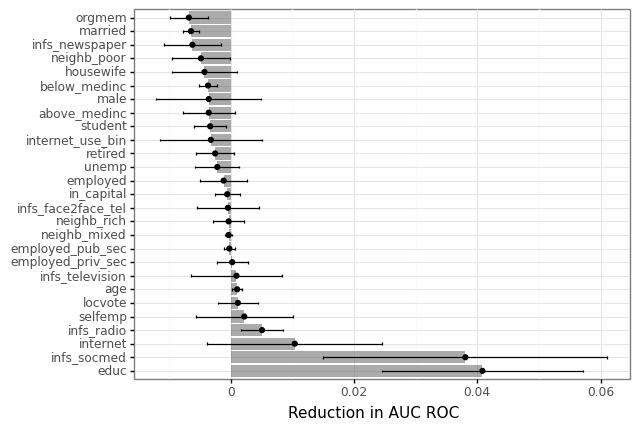

<ggplot: (8784945678589)>

In [126]:
# Plot
(
    ggplot(vi_dat,
        aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

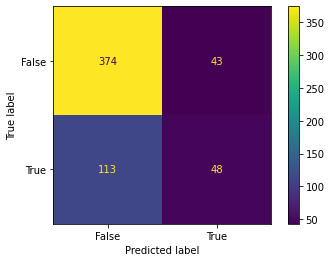

In [127]:
score, best_mod, pred_y, confusion, train_X, test_X, train_y, test_y = trustgov(morocco)

In [128]:
score

0.7355972800733973

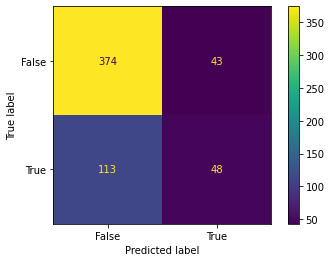

In [129]:
confusion.figure_

In [130]:
best_mod

Pipeline(steps=[('pre_process', MinMaxScaler()),
                ('model',
                 RandomForestClassifier(max_depth=6, max_features=5,
                                        n_estimators=1500))])

In [131]:
pred_threshold1 = (best_mod.predict_proba(test_X)[:,1] >= threshold1).astype(int)

In [132]:
pred_threshold1

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [133]:
pred_threshold2 = (best_mod.predict_proba(test_X)[:,1] >= threshold2).astype(int)

In [134]:
pred_threshold2

array([0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,

In [135]:
# permutation
vi = permutation_importance(best_mod,train_X,train_y,n_repeats=5)

In [136]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                        vi = vi['importances_mean'],
                        std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,age,0.052249,0.004637,0.042976,0.061522
1,locvote,0.048558,0.005278,0.038002,0.059114
2,infs_television,0.019608,0.003363,0.012882,0.026333
3,educ,0.017186,0.003291,0.010604,0.023767
4,infs_socmed,0.011534,0.002802,0.005931,0.017137
5,employed,0.009458,0.000937,0.007584,0.011332
6,male,0.007843,0.000782,0.006279,0.009408
7,internet,0.007382,0.001335,0.004711,0.010052
8,unemp,0.006690,0.001530,0.003629,0.009750
9,infs_face2face_tel,0.006344,0.001749,0.002845,0.009842


In [137]:
vi_dat.to_csv("variable importance csv/morocco_y1")

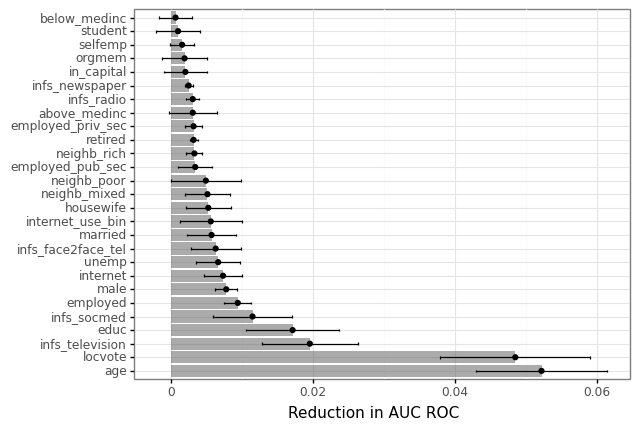

<ggplot: (8784932139668)>

In [138]:
# Plot
(
    ggplot(vi_dat,
        aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

In [139]:
egypt.drop(columns = "locvote", inplace = True)

In [140]:
egypt.dropna(inplace = True)

In [141]:
egypt.isna().sum()

below_medinc               0
above_medinc               0
in_capital                 0
married                    0
employed                   0
employed_pub_sec           0
employed_priv_sec          0
selfemp                    0
retired                    0
housewife                  0
student                    0
unemp                      0
neighb_rich                0
neighb_poor                0
neighb_mixed               0
educ                       0
male                       0
age                        0
orgmem                     0
internet                   0
internet_use_bin           0
infs_face2face_tel         0
infs_newspaper             0
infs_radio                 0
infs_television            0
infs_socmed                0
y_2_dem_pref_not_in_dem    0
y_1_trust_gov              0
dtype: int64

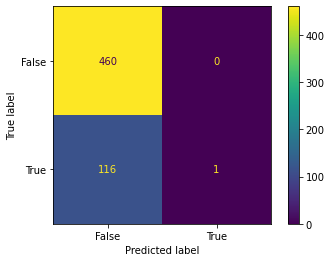

In [142]:
score, best_mod, pred_y, confusion, train_X, test_X, train_y, test_y = dempref(egypt)

In [143]:
score

0.7246340875709874

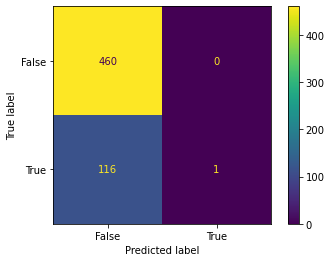

In [144]:
confusion.figure_

In [145]:
best_mod

Pipeline(steps=[('pre_process', MinMaxScaler()),
                ('model',
                 RandomForestClassifier(max_depth=6, max_features=5,
                                        n_estimators=500))])

In [146]:
pred_threshold1 = (best_mod.predict_proba(test_X)[:,1] >= threshold1).astype(int)

In [147]:
pred_threshold1

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [148]:
pred_threshold2 = (best_mod.predict_proba(test_X)[:,1] >= threshold2).astype(int)

In [149]:
pred_threshold2

array([0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,

In [150]:
# permutation
vi = permutation_importance(best_mod,train_X,train_y,n_repeats=5)

In [151]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                        vi = vi['importances_mean'],
                        std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,infs_socmed,1.965318e-03,0.000283,0.001399,0.002532
1,employed_priv_sec,1.965318e-03,0.000283,0.001399,0.002532
2,internet_use_bin,1.734104e-03,0.000517,0.000700,0.002768
3,educ,1.618497e-03,0.001387,-0.001156,0.004393
4,age,1.618497e-03,0.000674,0.000270,0.002967
5,employed,1.502890e-03,0.000283,0.000937,0.002069
6,infs_television,1.271676e-03,0.000674,-0.000077,0.002620
7,above_medinc,6.936416e-04,0.000674,-0.000655,0.002042
8,internet,5.780347e-04,0.000633,-0.000688,0.001844
9,housewife,4.624277e-04,0.000433,-0.000403,0.001328


In [152]:
vi_dat.to_csv("variable importance csv/egypt_y2")

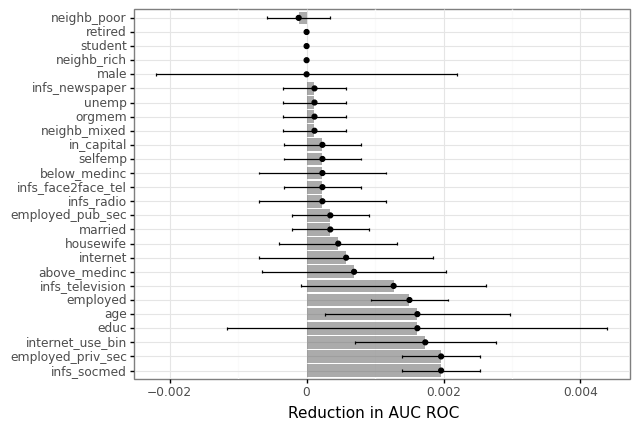

<ggplot: (8784932942755)>

In [153]:
# Plot
(
    ggplot(vi_dat,
        aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

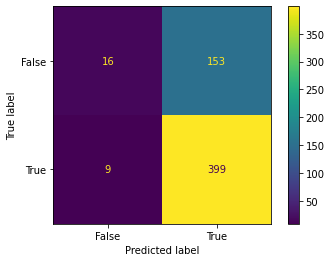

In [154]:
score, best_mod, pred_y, confusion, train_X, test_X, train_y, test_y = trustgov(egypt)

In [155]:
score

0.6544101863621059

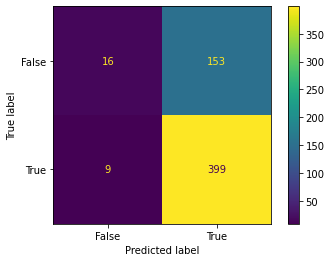

In [156]:
confusion.figure_

In [157]:
best_mod

Pipeline(steps=[('pre_process', MinMaxScaler()),
                ('model',
                 RandomForestClassifier(max_depth=8, max_features=5,
                                        n_estimators=1000))])

In [158]:
pred_threshold1 = (best_mod.predict_proba(test_X)[:,1] >= threshold1).astype(int)

In [159]:
pred_threshold1

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [160]:
pred_threshold2 = (best_mod.predict_proba(test_X)[:,1] >= threshold2).astype(int)

In [161]:
pred_threshold2

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [162]:
# permutation
vi = permutation_importance(best_mod,train_X,train_y,n_repeats=5)

In [163]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                        vi = vi['importances_mean'],
                        std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,age,0.035491,0.002441,0.030608,0.040374
1,infs_television,0.026243,0.003757,0.018729,0.033756
2,internet_use_bin,0.019306,0.002601,0.014105,0.024507
3,unemp,0.018266,0.001699,0.014868,0.021664
4,married,0.012601,0.002295,0.008012,0.017191
5,infs_socmed,0.010983,0.001791,0.007401,0.014565
6,male,0.010289,0.000994,0.008300,0.012278
7,employed_priv_sec,0.009133,0.000925,0.007283,0.010983
8,orgmem,0.009133,0.001842,0.005448,0.012818
9,educ,0.008555,0.001610,0.005334,0.011775


In [164]:
vi_dat.to_csv("variable importance csv/egypt_y1")

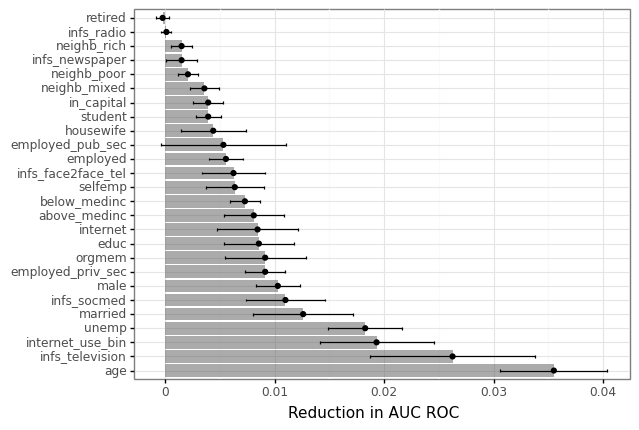

<ggplot: (8784932485467)>

In [165]:
# Plot
(
    ggplot(vi_dat,
        aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

In [166]:
algeria.dropna(inplace = True)

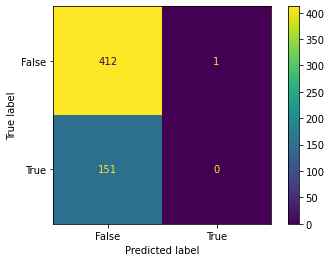

In [167]:
score, best_mod, pred_y, confusion, train_X, test_X, train_y, test_y = dempref(algeria)

In [168]:
score

0.6151840496011525

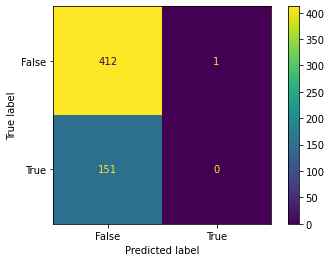

In [169]:
confusion.figure_

In [170]:
best_mod

Pipeline(steps=[('pre_process', MinMaxScaler()),
                ('model',
                 RandomForestClassifier(max_depth=6, max_features=5,
                                        n_estimators=1500))])

In [171]:
pred_threshold1 = (best_mod.predict_proba(test_X)[:,1] >= threshold1).astype(int)

In [172]:
pred_threshold1

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [173]:
pred_threshold2 = (best_mod.predict_proba(test_X)[:,1] >= threshold2).astype(int)

In [174]:
pred_threshold2

array([0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,

In [175]:
# permutation
vi = permutation_importance(best_mod,train_X,train_y,n_repeats=5)

In [176]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                        vi = vi['importances_mean'],
                        std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,infs_newspaper,0.002839,0.000237,0.002365,0.003312
1,internet_use_bin,0.001656,0.000443,0.000771,0.002541
2,educ,0.001656,0.000443,0.000771,0.002541
3,age,0.001301,0.000579,0.000142,0.002460
4,employed,0.001301,0.000237,0.000828,0.001774
5,retired,0.001301,0.000579,0.000142,0.002460
6,male,0.001064,0.000443,0.000179,0.001950
7,locvote,0.001064,0.000690,-0.000315,0.002444
8,internet,0.000828,0.000290,0.000248,0.001407
9,in_capital,0.000591,0.000000,0.000591,0.000591


In [177]:
vi_dat.to_csv("variable importance csv/algeria_y2")

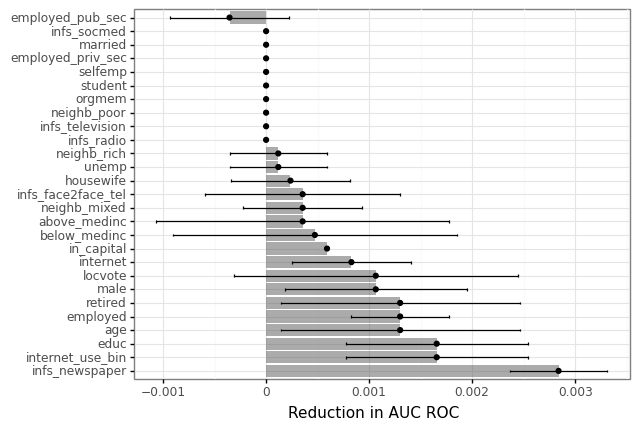

<ggplot: (8784931861038)>

In [178]:
# Plot
(
    ggplot(vi_dat,
        aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

In [179]:
from sklearn.datasets import make_classification

In [180]:
# generate dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=4)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2, stratify=y)
# fit a model
model = Logit(solver='lbfgs')
model.fit(trainX, trainy)

LogisticRegression()

In [181]:
# predict probabilities
yhat = model.predict_proba(testX)
yhat

array([[9.92758703e-01, 7.24129721e-03],
       [9.96495510e-01, 3.50448974e-03],
       [9.99867566e-01, 1.32433775e-04],
       ...,
       [9.98780592e-01, 1.21940764e-03],
       [9.99705540e-01, 2.94459735e-04],
       [9.99603387e-01, 3.96613003e-04]])

In [182]:
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]

In [183]:
# keep probabilities for the positive outcome only
yhat

array([0.0072413 , 0.00350449, 0.00013243, ..., 0.00121941, 0.00029446,
       0.00039661])

In [184]:
# calculate roc curves
fpr, tpr, thresholds = m.roc_curve(testy, yhat)
print(fpr) 
print(tpr) 
print(thresholds)

[0.00000000e+00 0.00000000e+00 0.00000000e+00 2.02020202e-04
 2.02020202e-04 6.06060606e-04 6.06060606e-04 1.01010101e-03
 1.01010101e-03 1.21212121e-03 1.21212121e-03 1.81818182e-03
 1.81818182e-03 3.63636364e-03 3.63636364e-03 5.65656566e-03
 5.65656566e-03 6.66666667e-03 6.66666667e-03 8.48484848e-03
 8.48484848e-03 1.01010101e-02 1.01010101e-02 1.37373737e-02
 1.37373737e-02 1.63636364e-02 1.63636364e-02 2.38383838e-02
 2.38383838e-02 4.28282828e-02 4.28282828e-02 4.56565657e-02
 4.56565657e-02 5.29292929e-02 5.29292929e-02 9.91919192e-02
 9.91919192e-02 1.57979798e-01 1.57979798e-01 2.35555556e-01
 2.35555556e-01 2.65252525e-01 2.65252525e-01 1.00000000e+00]
[0.   0.02 0.56 0.56 0.58 0.58 0.62 0.62 0.66 0.66 0.68 0.68 0.7  0.7
 0.72 0.72 0.74 0.74 0.76 0.76 0.78 0.78 0.8  0.8  0.82 0.82 0.84 0.84
 0.86 0.86 0.88 0.88 0.9  0.9  0.92 0.92 0.94 0.94 0.96 0.96 0.98 0.98
 1.   1.  ]
[1.99999835e+00 9.99998347e-01 4.96107783e-01 4.64133790e-01
 4.37378298e-01 4.10290652e-01 3.60605429e-

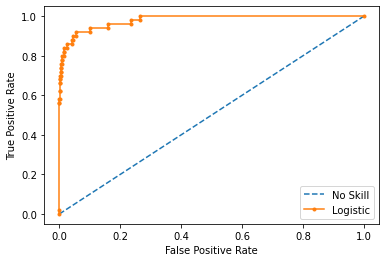

In [185]:
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

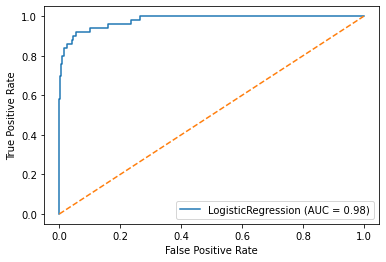

In [186]:
m.plot_roc_curve(model, testX, testy)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')